In [ ]:
import numpy as onp
import matplotlib.pyplot as plt
import jax.numpy as np#jnp
import glob
import os
import pickle

from jax import random, vmap, jit, grad, ops, lax, tree_util, device_put, device_get, jacobian, jacfwd, jacrev, jvp
import cvxpy as cp

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as colors

import seaborn as sns
sns.set_style('darkgrid')
palette = sns.color_palette()

#import celluloid
import jax
print(jax.devices())



In [2]:
data_dir = "data/csv_files_postprocessing/"
vel_dir = data_dir + 'velocity_limits/'
fig_path = 'figures/vel_lim/'
save = True

In [3]:
# Velocity Limits



x_lim = [0., 1.]
y_lim = [-0.5, 0.5]
z_lim = [0., 0.5]
vdot_lim = [-1., 1.]

ws_lim = onp.vstack((x_lim, y_lim, z_lim, vdot_lim, vdot_lim, vdot_lim))
# Define Dynamical System

eps = 1.0
# X = [x, y, z, xdot, ydot, zdot]
# Xdot = [xdot, ydot, zdot, xddot, yddot,  zdot] = [u1*cos(theta), u1*sin(theta), u2]
def dynamics(x, u):
    # continuous time: xdot = f(x(t)) + g(x(t))u((t))
    # (xdot=[u1*cos(theta), u1*sin(theta), u2], x = x0 + xdot*dt)    
    return onp.diag(np.array([x[3], x[4], x[5], u[0], u[1], u[2]]))


nSafe = 10
nUnsafe = 10



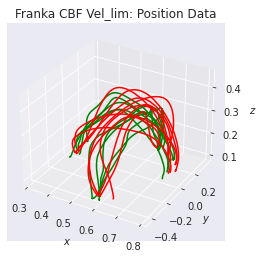

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
safe_traj = []
for i in range(0, nSafe):
    fname = vel_dir + 'slow/' + str(i+1) + '_eePosition.txt'
    pos = onp.loadtxt(fname, delimiter=',').T
    safe_traj.append(pos)
    ax.plot(pos[:,0], pos[:,1], pos[:,2], 'g')

unsafe_traj = []
tte_list = []
for i in range(0, nUnsafe):
    fname = vel_dir + 'fast/' + str(i+1) + '_eePosition.txt'
    pos = onp.loadtxt(fname, delimiter=',').T
    unsafe_traj.append(pos)
    ax.plot(pos[:,0], pos[:,1], pos[:,2], 'r')
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Franka CBF Vel_lim: Position Data')
if save: plt.savefig(fig_path + 'demonstration_data.pdf')
plt.show()

Text(0.5, 0.92, 'Franka CBF Velocity Limits: Velocity Data')

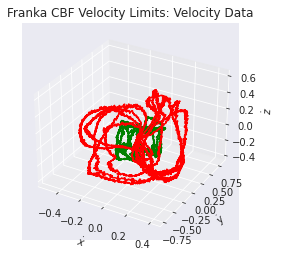

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
safe_vel = []
for i in range(0, nSafe):
    fname = vel_dir + 'slow/' + str(i+1) + '_eeVelocity.txt'
    vel = onp.loadtxt(fname, delimiter=',').T
    safe_vel.append(vel)
    ax.plot(vel[:,0], vel[:,1], vel[:,2], 'g')

unsafe_vel = []
for i in range(0, nUnsafe):
    fname = vel_dir + 'fast/' + str(i+1) + '_eeVelocity.txt'
    vel = onp.loadtxt(fname, delimiter=',').T
    unsafe_vel.append(vel)
    ax.plot(vel[:,0], vel[:,1], vel[:,2], 'r')
ax.set_xlabel('$\dot{x}$')
ax.set_ylabel('$\dot{y}$')
ax.set_zlabel('$\dot{z}$')
ax.set_title('Franka CBF Velocity Limits: Velocity Data')

In [6]:
print(len(safe_traj), len(safe_vel))

10 10


In [7]:
xtraj = onp.hstack((safe_traj[0], safe_vel[0]))
safe_pts = xtraj
for i in range(1, nSafe): 
    xtraj = onp.hstack((safe_traj[i], safe_vel[i]))
    safe_pts = onp.vstack((safe_pts, xtraj))

xtraj = onp.hstack((unsafe_traj[0], unsafe_vel[0]))
unsafe_pts = xtraj
for i in range(1, nUnsafe): 
    xtraj = onp.hstack((unsafe_traj[i], unsafe_vel[i]))
    unsafe_pts = onp.vstack((unsafe_pts, xtraj))
    
print(safe_pts.shape, unsafe_pts.shape)

unsafe_ttelist = onp.ones(len(unsafe_pts))

(70045, 6) (39347, 6)


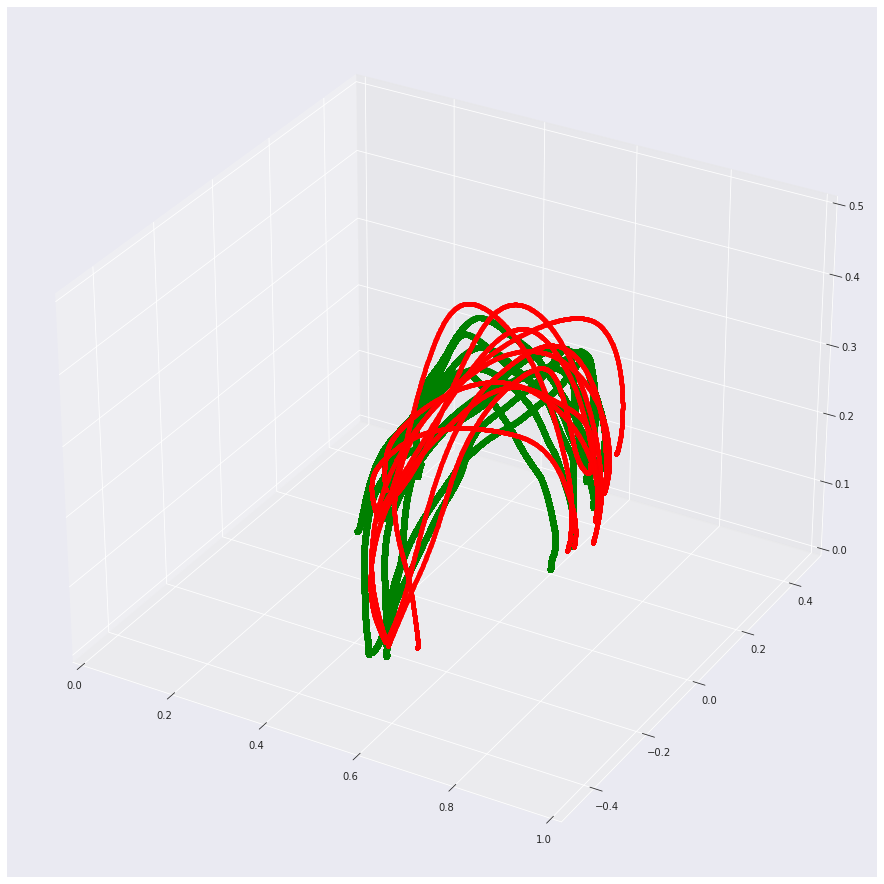

In [8]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.plot(safe_pts[:,0], safe_pts[:,1], safe_pts[:,2], 'g*')

ax.plot(unsafe_pts[:,0], unsafe_pts[:,1], unsafe_pts[:,2], 'r.')

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_zlim(z_lim)
if save: plt.savefig(fig_path + 'demodata.pdf')
plt.show()

In [9]:
# Define reward lists
safe_rewards = onp.ones(len(safe_pts))*2.
unsafe_rewards = onp.ones(len(unsafe_pts))

In [10]:
# Define h model (i.e., RBF)

def rbf_means_stds(X, X_lim, n, k, set_means = 'uniform', fixed_stds=True, std=0.1):
    """ Generates means and standard deviations for Gaussian RBF kernel
    
    Arguments:
        X {numpy array, None} -- Mxn array of inputs (M: number of pts, n: dim of workspace); 
                                 None allowed if set_means = {'uniform', 'random'}
        X_lim {numpy array} -- nx2 array of limits (max,min) of workspace dimension (n: dim of workspace)
        n {int} -- Number of workspace dimensions
        k {int} -- Number of kernels
        set_means {string} -- string representing method of determining means. 
            Options: {'uniform'(default), 'random', 'inputs'}. 
            'uniform': equally spaced k points across workspace
            'random': randomly generated k points across workspace
            'input': directly use the first k input points (data points) as means (ideally k=M)
            TODO: 'kmeans': use kmeans on input points (data points) to generate
        fixed_stds {bool} -- set if fixed for all means or randomized
    
    Returns:
        means- numpy array -- A kxn array of final means/centers
        stds - numpy array -- A kx1 array of final stds
    """    
    set_means_options = ['uniform', 'random', 'inputs']
    assert set_means in set_means_options, "Invalid option for set_means"
    
    # Generate means
    if set_means == 'uniform':
        if n == 1:
            means = np.linspace(start=X_lim[0], stop=X_lim[1], 
                                num=k, endpoint=True)
        elif n == 2:
            x = np.linspace(start=X_lim[0,0], stop=X_lim[0,1], 
                            num=k, endpoint=True)
            y = np.linspace(start=X_lim[1,0], stop=X_lim[1,1], 
                            num=k, endpoint=True)
            XX, YY = np.meshgrid(x,y)
            means = np.array([XX.flatten(), YY.flatten()]).T
        else: 
            pts = []
            for i in range(X_lim.shape[0]): 
                pts.append(np.linspace(start=X_lim[i,0], stop=X_lim[i,1], num=k, endpoint=True))
            pts = np.array(pts)
            pts = tuple(pts)
            D = np.meshgrid(*pts)
            means = np.array([D[i].flatten() for i in range(len(D))]).T
            
    if set_means == 'random':
        means = np.random.uniform(low=X_lim[:,0], high=X_lim[:,1], size=(k**(1/2),n))
    if set_means =='inputs':
        assert X is not None, 'X invalid data input. Cannot be None-type'
        assert k==X.shape[0], 'Set_means inputs, num kernels must equal num of data points'
        means = X.copy()
    
    # Generate stds    
    if fixed_stds == True: 
        stds = np.ones((k**n,1))*std
    else: 
#         stds = np.random.uniform(low = 0.0001, high = std, size=(k**n,1))
        stds = random.uniform(rng.next(), minval=0.0001, maxval= std, shape=(k**n,1))
    stds = np.squeeze(stds)
    return means, stds
        
def alpha(x):
    return psi * x

def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * np.linalg.norm(x-c)**2)

def phi(X):
#     y = []
#     for i in range(X.shape[0]):
    a = np.array([rbf(X, c, s) for c, s, in zip(centers, stds)])
#         y.append(a)    
    return a#np.array(y)

def h_model(x, theta, bias):
#     print(x.shape, phi(x).shape, theta.shape, phi(x).dot(theta).shape, bias.shape)
#     print(x.type, theta.type, bias.type)
    return phi(x).dot(theta) + bias

(234, 6) (234,) (132, 6) (132,) (132,)


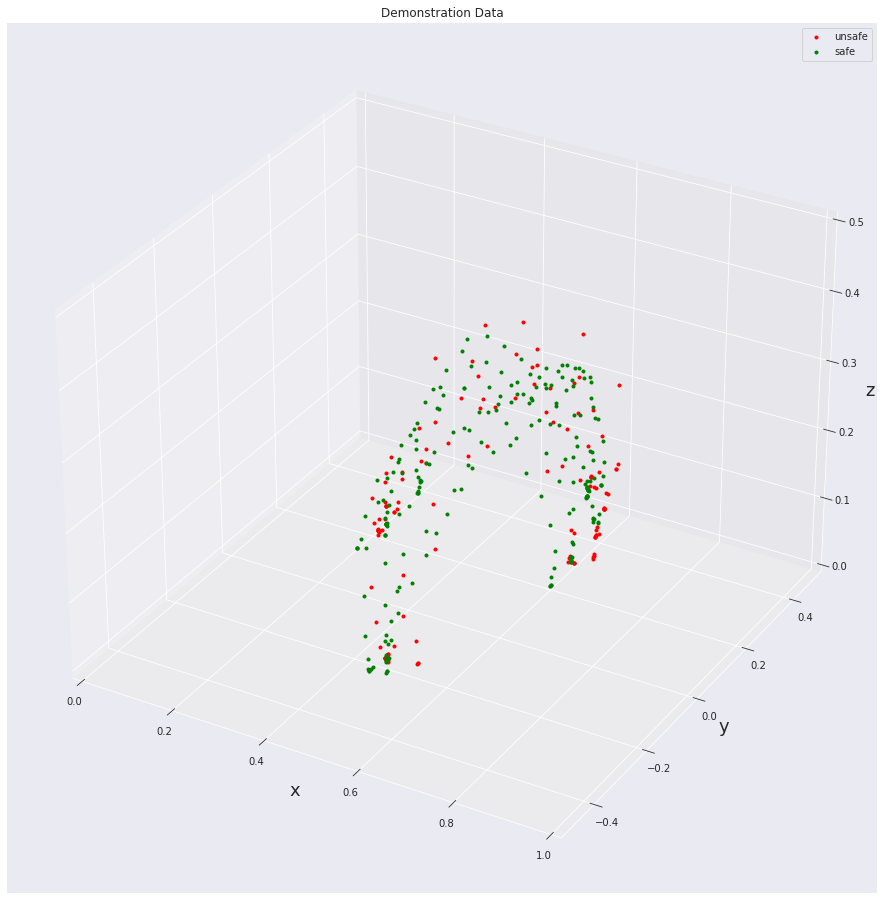

In [11]:
### Set up Minimization
# Sample Data 
n_safe_sample = 300#50
x_safe = safe_pts[::n_safe_sample]
safe_rewards = safe_rewards[::n_safe_sample]

n_unsafe_sample = 300#20
x_unsafe = unsafe_pts[::n_unsafe_sample]
unsafe_rewards = unsafe_rewards[::n_unsafe_sample]
unsafe_tte = unsafe_ttelist[::n_unsafe_sample]

print(x_safe.shape, safe_rewards.shape, x_unsafe.shape, unsafe_rewards.shape, unsafe_tte.shape)

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

ax.plot(x_unsafe[:, 0], x_unsafe[:, 1], x_unsafe[:, 2], 'r.', label='unsafe')
ax.plot(x_safe[:, 0], x_safe[:, 1], x_safe[:, 2], 'g.',label='safe')

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_zlim(z_lim)
ax.set_xlabel('x',fontsize=18)
ax.set_ylabel('y',fontsize=18)
ax.set_zlabel('z',fontsize=18)
plt.title('Demonstration Data')
plt.legend()
if save: plt.savefig(fig_path + 'cbf_data.pdf')
plt.show()

In [24]:
# Initialize Data
n_safe = len(x_safe)
n_unsafe = len(x_unsafe)

# Initialize RBF Parameters
n_dim_features = 3
x_dim = 6
n_features = n_dim_features**x_dim
u_dim = 2
psi = 1.0
dt = 0.1
mu_dist = (ws_lim[:, 1]-ws_lim[:,0])/n_dim_features

rbf_std = onp.max(mu_dist) * 0.5 #0.1#1.0
print(rbf_std)
# rbf_std = 0.5
centers, stds = rbf_means_stds(X=None, X_lim = np.array([x_lim,y_lim,z_lim, vdot_lim, vdot_lim, vdot_lim]), 
                               n=x_dim, k=n_dim_features, fixed_stds=True, std=rbf_std)
print(centers.shape, stds.shape)
# rf_weights = (random.uniform(rng.next(), minval=0, maxval= 1., shape=(n_features,)), 
#               random.uniform(rng.next(), minval=0, maxval=0.1, shape=(n_features,)))

# fig = plt.figure(figsize=(6, 6))
# ax = plt.axes(projection='3d')
# ax.scatter(centers[:, 0], centers[:, 1], centers[:,2])#, marker=m)

# # ax.axis('square')
# ax.set_xlim(x_lim)
# ax.set_ylim(y_lim)
# ax.set_xlabel('x', fontsize=18)
# ax.set_ylabel('y', fontsize=18)
# ax.zaxis.set_rotate_label(False)  # disable automatic rotation
# ax.set_zlabel(r'$\theta$', rotation=180, fontsize=18)
# plt.title('RBF Means')
# if save: plt.savefig(fig_path+'RBF Means on Workspace.pdf')
# plt.show()

0.3333333333333333
(729, 6) (729,)


(234,) (132,)
-1.0


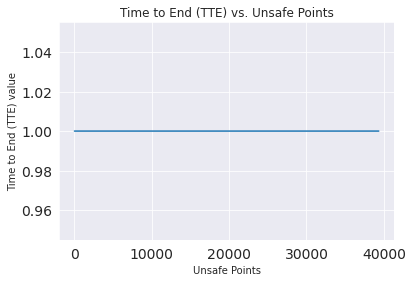

In [27]:
# Initialize variables
is_bias = False
is_slack_both = False
is_slack_safe = False
is_semisafe = False
is_artificial = False
theta = cp.Variable(n_features)#, nonneg=True)
assert not (is_slack_both and is_slack_safe), "Slack bool cannot be both and safe only"
if is_bias: bias = cp.Variable()
else: bias = 0.1

if is_slack_both: 
    safe_slack = cp.Variable(n_safe)
    unsafe_slack = cp.Variable(n_unsafe) 
elif is_slack_safe: 
    safe_slack = cp.Variable(n_safe)
else: unsafe_slack = cp.Variable(n_unsafe)



# Initialize reward parameters
r_scaling = 1.
safe_val = np.ones(n_safe)*2. # np.array(onp.squeeze(safe_rewards)*r_scaling)#np.ones(n_safe)*0.3
unsafe_val = np.ones(n_unsafe)*-1.0#*-0.5#*-0.1
if is_semisafe: 
    semisafe_val = np.ones(n_semisafe)*0.5# np.array(onp.squeeze(semisafe_rewards)*r_scaling)#np.ones(n_semisafe)*0.
    gamma_dyn = np.ones(n_semisafe)*0.1
unsafe_tte = unsafe_ttelist**3
    
if is_artificial: art_safe_val = np.ones(len(art_safe_pts))*0.1#*0.5
print(safe_val.shape, unsafe_val.shape)#, semisafe_val.shape)#, art_safe_val.shape)
print(unsafe_val[0])

plt.plot(unsafe_tte)
plt.xlabel('Unsafe Points')
plt.ylabel('Time to End (TTE) value')
plt.title('Time to End (TTE) vs. Unsafe Points')
if save: plt.savefig(fig_path + 'unsafe_tte_list.pdf')
plt.show()

In [28]:
# Initialize cost
h_cost = 0
param_cost = 0
slack_cost = 0

## Define Constraints
constraints = []


# Safe Constraints
print("SAFE CONSTRAINTS")
phis_safe = [phi(x) for x in x_safe]
if is_slack_both or is_slack_safe: 
    print("Adding safe slack constraints")
    for i in range(n_safe): 
        h_cost += cp.sum_squares(theta.T@np.squeeze(phis_safe[i]) + bias) # cost of norm(alpha_i * phi(x,xi) + b)
        constraints.append((theta.T@np.squeeze(phis_safe[i]) + bias) >= safe_val[i]+safe_slack[i])
        constraints.append(safe_slack[i] <= 0.)        
else: 
    print("Adding no slack constraints")
    for i in range(n_safe): 
        h_cost += cp.sum_squares(theta.T@np.squeeze(phis_safe[i]) + bias) # cost of norm(alpha_i * phi(x,xi) + b)
        constraints.append((theta.T@np.squeeze(phis_safe[i]) + bias) >= safe_val[i])

if is_artificial: 
    print("ADDING ARTIFICIAL SAFE PTS")
    phis_artificial = [phi(x) for x in art_safe_pts]        
    for i in range(len(art_safe_pts)): 
        h_cost += cp.sum_squares(theta.T@np.squeeze(phis_artificial[i]) + bias) # cost of norm(alpha_i * phi(x,xi) + b)
        constraints.append((theta.T@np.squeeze(phis_artificial[i]) + bias) >= art_safe_val[i])
#Unsafe Constraints
print("UNSAFE CONSTRAINTS")
phis_unsafe = [phi(x) for x in x_unsafe]
if is_slack_both or not is_slack_safe:        
    print("Adding unsafe slack constraints")
    for i in range(n_unsafe):
        h_cost += cp.sum_squares(theta.T@np.squeeze(phis_unsafe[i]) + bias) # cost of norm(alpha_i * phi(x,xi) + b)
        constraints.append((theta.T@np.squeeze(phis_unsafe[i]) + bias) <= unsafe_val[i]+ unsafe_tte[i] * unsafe_slack[i])
        constraints.append(unsafe_slack[i] >= 0.)
else:
    print("adding no slack constraints")
    for i in range(n_unsafe):
        h_cost += cp.sum_squares(theta.T@np.squeeze(phis_unsafe[i]) + bias) # cost of norm(alpha_i * phi(x,xi) + b)
        constraints.append((theta.T@np.squeeze(phis_unsafe[i]) + bias) <= unsafe_val[i])

if is_semisafe: 
    # Boundary Constraints: TODO: need to include semisafe control u values
    print("BOUNDARY CONSTRAINTS")

    phis_semisafe = [phi(x) for x in x_semisafe]
    print("SEMISAFE H CONSTRAINTS")
    for i in range(n_semisafe): 
        h_cost += cp.sum_squares(theta.T@np.squeeze(phis_semisafe[i]) + bias) # cost of norm(alpha_i * phi(x,xi) + b)
        constraints.append((theta.T@np.squeeze(phis_semisafe[i]) + bias) >= semisafe_val[i])

    print("SEMISAFE DERIVATIVE CONSTRAINTS")
    
#     def q(x, u):
#         dh = grad(h_model, argnums=0)(x, theta, bias)
#         return np.dot(dh, dynamics(x, u)) + h_model(x, theta, bias)

#     qs = q(x_semisafe, u_semisafe)
#     for i in range(n_semisafe):
#         constraints.append((qs[i] >= gamma_dyn[i]))

    Dphixdots = device_get(
        vmap(lambda x, u: np.dot(jacobian(phi, argnums=0)(x), dynamics(x, u)), 
             in_axes=(0, 0))(x_semisafe, u_semisafe))
    gamma_xu_fillers=gamma_dyn*np.ones((x_semisafe.shape[0],))
    for this_phi, this_Dphixdot, this_gamma in zip(phis_semisafe, Dphixdots, gamma_xu_fillers):
    #     constraints.append((theta.T * (this_Dphixdot.T + this_phi) + bias) >= this_gamma)
        constraints.append((theta.T @ (this_Dphixdot.T) + theta.T@(this_phi) + bias) >= this_gamma)    
print('All CONSTRAINTS DEFINED')

SAFE CONSTRAINTS
Adding no slack constraints
UNSAFE CONSTRAINTS
Adding unsafe slack constraints
All CONSTRAINTS DEFINED


In [29]:


# Add Constraints on parameter values
for i in range(theta.shape[0]):
    constraints.append(cp.abs(theta[i]) <= 5.)


In [30]:
## Define Objective

param_cost = cp.sum_squares(theta) #+ bias ** 2 # l2-norm on parameters

if is_slack_both: slack_cost = cp.sum_squares(safe_slack) + cp.sum_squares(unsafe_slack) 
elif is_slack_safe: slack_cost = cp.sum_squares(safe_slack) # Norm on slack variables
else: slack_cost = cp.sum_squares(unsafe_slack) # Norm on slack variables
slack_weight = 10.
h_weight = 1.
param_weight = 1.#500.
obj = cp.Minimize(param_weight * param_cost + slack_weight * slack_cost + h_weight * h_cost)
print('All costs defined')

All costs defined


In [31]:
params = None
bias_param = None
prob = cp.Problem(obj, constraints)
result = prob.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jun 03 12:20:36 PM: Your problem has 861 variables, 1227 constraints, and 0 parameters.
(CVXPY) Jun 03 12:20:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 03 12:20:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 03 12:20:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 03 12:20:36 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 03 12:20:36 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

In [32]:
params = theta.value
if is_bias: bias_param = bias.value
else: bias_param = None

if is_slack_both: 
    safe_slack_param = safe_slack.value
    unsafe_slack_param  = unsafe_slack.value
elif is_slack_safe: 
    safe_slack_param = safe_slack.value
    unsafe_slack_param  = None
else: 
    safe_slack_param = None
    unsafe_slack_param  = unsafe_slack.value

In [34]:
# grid to see what the superlevel set h(x) is
num_pts = 30
x1 = np.linspace(x_lim[0], x_lim[1], num=num_pts)
x2 = np.linspace(y_lim[0], y_lim[1], num=num_pts)
if not is_bias: bias_param = bias
print(bias_param)

0.1


In [37]:
if is_semisafe: 
    data = {
       "theta": params,
        "bias": bias_param,
        "safe_slack": safe_slack_param,
        "unsafe_slack": unsafe_slack_param,
        "x_safe": x_safe,
        "x_unsafe": x_unsafe,
        "x_semisafe": x_semisafe,
        "u_semisafe": u_semisafe,
        "is_bias": is_bias,
        "is_semisafe": is_semisafe,
        "is_slack_safe": is_slack_safe,
        "pos_demos": safe_demos,
        "pos_demos_u": safe_u,
        "neg_demos": unsafe_demos,
        "unsafe_demos_u": unsafe_u,
        "semisafe_demos": semisafe_demos,
        "semisafe_demos_u": semisafe_u,
        "safe_reward_values": safe_val,
        "unsafe_reward_values": unsafe_val,
        "semisafe_reward_values": semisafe_val,
        "gamma_dyn": gamma_dyn
    }
else: 
    data = {
       "theta": params,
        "bias": bias_param,
        "safe_slack": safe_slack_param,
        "unsafe_slack": unsafe_slack_param,
        "x_safe": x_safe,
        "x_unsafe": x_unsafe,
        "is_bias": is_bias,
        "is_semisafe": is_semisafe,
        "is_slack_safe": is_slack_safe,
        "safe_reward_values": safe_val,
        "unsafe_reward_values": unsafe_val,
        }
if save: pickle.dump(data, open( fig_path+"data_dict.p", "wb" ) )


In [53]:
num_pts = 10
x1 = np.linspace(x_lim[0], x_lim[1], num=num_pts)
x2 = np.linspace(y_lim[0], y_lim[1], num=num_pts)
x3 = np.linspace(z_lim[0], z_lim[1], num=num_pts)
x4 = np.linspace(vdot_lim[0], vdot_lim[1], num=num_pts)
x5 = np.linspace(vdot_lim[0], vdot_lim[1], num=num_pts)
x6 = np.linspace(vdot_lim[0], vdot_lim[1], num=num_pts)
hvals = vmap(lambda s1: vmap(lambda s2: h_model(np.array([[0.5,0.,0.25, s1, 0.,s2]]), params, bias_param))(x6))(x4).squeeze()


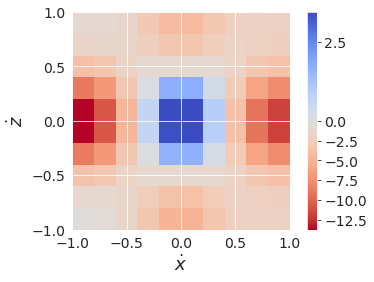

In [60]:
hvals = vmap(lambda s1: vmap(lambda s2: h_model(np.array([[0.5,0.,0.25, s1, 0.,s2]]), params, bias_param))(x6))(x4).squeeze()

divnorm = colors.TwoSlopeNorm(vmin=np.min(hvals), vcenter=0., vmax=np.max(hvals))

fig,ax = plt.subplots()
im = ax.imshow(hvals.T, extent=[vdot_lim[0],vdot_lim[1], vdot_lim[0], vdot_lim[1]], origin='lower',norm=divnorm,cmap=cm.coolwarm_r)
fig.colorbar(im)
ax.set_xlabel('$\dot{x}$', fontsize=18)
ax.set_ylabel('$\dot{z}$', fontsize=18)
if save: plt.savefig(fig_path +'cbf-xz_vel.pdf')


Text(0, 0.5, '$z$')

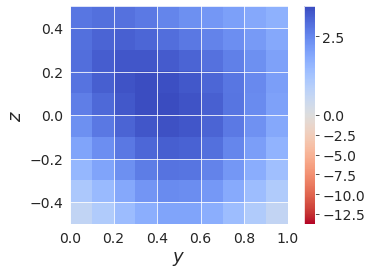

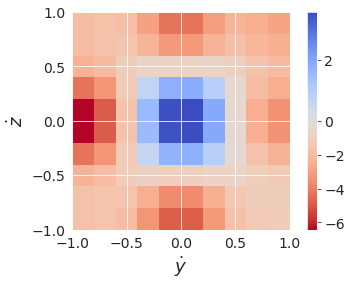

In [59]:
hvals = vmap(lambda s1: vmap(lambda s2: h_model(np.array([[0.5,0.,0.25, 0., s1,s2]]), params, bias_param))(x6))(x5).squeeze()
fig,ax = plt.subplots()
im = ax.imshow(hvals.T, extent=[vdot_lim[0],vdot_lim[1], vdot_lim[0], vdot_lim[1]], origin='lower',norm=divnorm,cmap=cm.coolwarm_r)
fig.colorbar(im)
ax.set_xlabel('$\dot{y}$', fontsize=18)
ax.set_ylabel('$\dot{z}$', fontsize=18)
if save: plt.savefig(fig_path +'cbf-yz_vel.pdf')


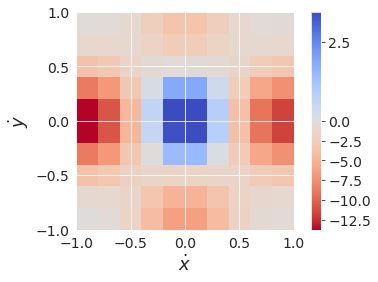

In [61]:
hvals = vmap(lambda s1: vmap(lambda s2: h_model(np.array([[0.5,0.,0.25, s1, s2,0.]]), params, bias_param))(x5))(x4).squeeze()
fig,ax = plt.subplots()
im = ax.imshow(hvals.T, extent=[vdot_lim[0],vdot_lim[1], vdot_lim[0], vdot_lim[1]], origin='lower',norm=divnorm,cmap=cm.coolwarm_r)
fig.colorbar(im)
ax.set_xlabel('$\dot{x}$', fontsize=18)
ax.set_ylabel('$\dot{y}$', fontsize=18)
if save: plt.savefig(fig_path +'cbf-xy_vel.pdf')

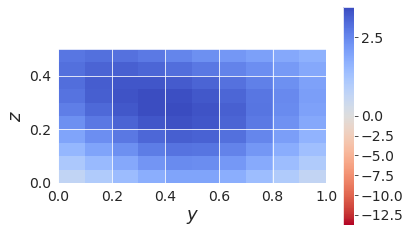

In [67]:
hvals = vmap(lambda s1: vmap(lambda s2: h_model(np.array([[0.5,s1,s2, 0.1, .1,0.1]]), params, bias_param))(x3))(x2).squeeze()
fig,ax = plt.subplots()
im = ax.imshow(hvals.T, extent=[x_lim[0],x_lim[1], z_lim[0], z_lim[1]], origin='lower',norm=divnorm,cmap=cm.coolwarm_r)
fig.colorbar(im)
ax.set_xlabel('$y$', fontsize=18)
ax.set_ylabel('$z$', fontsize=18)
if save: plt.savefig(fig_path +'cbf-yz_pos.pdf')

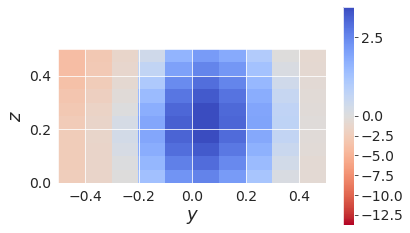

In [66]:
hvals = vmap(lambda s1: vmap(lambda s2: h_model(np.array([[s1,s2,0.25, 0.1, .1,0.1]]), params, bias_param))(x2))(x1).squeeze()
fig,ax = plt.subplots()
im = ax.imshow(hvals.T, extent=[y_lim[0],y_lim[1], z_lim[0], z_lim[1]], origin='lower',norm=divnorm,cmap=cm.coolwarm_r)
fig.colorbar(im)
ax.set_xlabel('$y$', fontsize=18)
ax.set_ylabel('$z$', fontsize=18)
if save: plt.savefig(fig_path +'cbf-xy_pos.pdf')

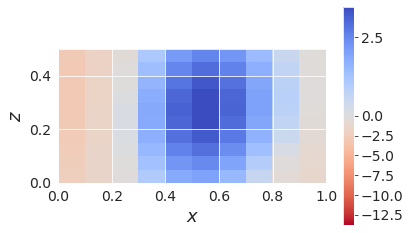

In [65]:
hvals = vmap(lambda s1: vmap(lambda s2: h_model(np.array([[s1,0.,s2, 0.1, .1,0.1]]), params, bias_param))(x3))(x1).squeeze()
fig,ax = plt.subplots()
im = ax.imshow(hvals.T, extent=[x_lim[0],x_lim[1], z_lim[0], z_lim[1]], origin='lower',norm=divnorm,cmap=cm.coolwarm_r)
fig.colorbar(im)
ax.set_xlabel('$x$', fontsize=18)
ax.set_ylabel('$z$', fontsize=18)
if save: plt.savefig(fig_path +'cbf-xz_pos.pdf')